# Let's Help Santa!

In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import json
import csv
import matplotlib.pyplot as plt
import cairocffi
from scipy.spatial import Delaunay
import networkx as nx
from tqdm.notebook import trange, tqdm

### Question 9
Report the number of nodes and edges in $G$.

In [2]:
# Read the CSV file with specific columns
df = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])

# Filter rows where the month is December and drop the 'month' column
df = df[df['month'] == 12].drop(columns=['month'])
gd = df.values
# Convert DataFrame to numpy array
data_array = df.to_numpy()

# Initialize an empty dictionary to store graph data
graph_dict = {}

# Populate the dictionary with mean travel times
for sourceid, dstid, mean_travel_time in data_array:
    key = tuple(sorted([int(sourceid), int(dstid)]))
    if key in graph_dict:
        graph_dict[key].append(mean_travel_time)
    else:
        graph_dict[key] = [mean_travel_time]

# Write the graph data to a text file
with open('graph_data.txt', 'w') as file:
    for loc, times in graph_dict.items():
        file.write(f'{loc[0]} {loc[1]} {np.mean(times):.2f}\n')

# Read the graph data from the text file and create the graph
g = ig.Graph.Read(f='graph_data.txt', format='ncol', directed=False)

# Get the giant component of the graph
giant_component = g.components().giant()

print(f'Number of nodes: {len(giant_component.vs)}\nNumber of Edges: {len(giant_component.es)}')

Number of nodes: 2649
Number of Edges: 1004955


### Question 10
Build a minimum spanning tree (MST) of graph $G$. Report the street addresses near the two endpoints (the centroid locations) of a few edges. Are the results intuitive?

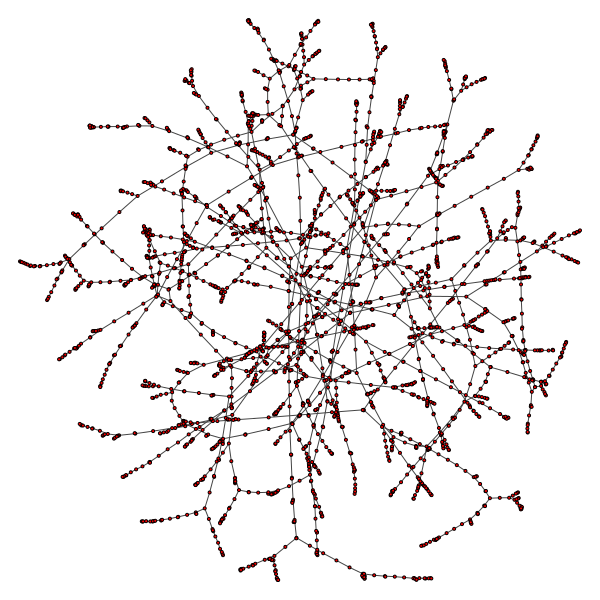

In [3]:
minimum_spanning_tree = giant_component.spanning_tree(weights=giant_component.es['weight'])
out = ig.plot(minimum_spanning_tree, vertex_size=3)
out.save("Q10.png")
out

In [4]:
location_data = {}
with open('los_angeles_censustracts.json', 'r') as file:
    data = json.loads(file.readline())
    for feature in data['features']:
        coords = np.array(feature['geometry']['coordinates'][0][0])
        location_data[feature['properties']['MOVEMENT_ID']] = {
            'address': feature['properties']['DISPLAY_NAME'],
            'mean_coords': np.mean(coords.reshape(-1, 2), axis=0)
        }

minimum_spanning_tree_edges = minimum_spanning_tree.es()
print("Coordinates near the two endpoints (the centroid locations) of a few edges:")

for edge in minimum_spanning_tree_edges[:5]:
    start_vertex = minimum_spanning_tree.vs[edge.tuple[0]]['name']
    end_vertex = minimum_spanning_tree.vs[edge.tuple[1]]['name']
    start_location = location_data[str(start_vertex)]
    end_location = location_data[str(end_vertex)]
    
    print(start_location['address'], start_location['mean_coords'],
          end_location['address'], end_location['mean_coords'])

Coordinates near the two endpoints (the centroid locations) of a few edges:
Census Tract 554001 [-118.133298   33.904119] Census Tract 554002 [-118.141448   33.896526]
Census Tract 461700 [-118.159325   34.153604] Census Tract 460800 [-118.172425   34.180286]
Census Tract 302201 [-118.251349   34.146334] Census Tract 302202 [-118.248811   34.142665]
Census Tract 407101 [-117.967696   34.04101 ] Census Tract 407002 [-117.980572   34.051745]
Census Tract 433401 [-118.043316   34.058606] Census Tract 433402 [-118.038157   34.056957]


### Question 11
Determine what percentage of tirnagles in the graph (set of 3 points on the map) satisfy the triangle inequality. You do not need to inspect all tirangles, you can just estimate by random sampling of 1000 triangles.

In [5]:
triangles = []
while len(triangles) < 1000:
    points = np.random.randint(1, high=len(giant_component.vs), size=3)
    try:
        e1 = giant_component.get_eid(points[0], points[1])
        e2 = giant_component.get_eid(points[1], points[2])
        e3 = giant_component.get_eid(points[2], points[0])
        weights = [
            giant_component.es['weight'][e1],
            giant_component.es['weight'][e2],
            giant_component.es['weight'][e3]
        ]
        triangles.append(weights)
    except:
        continue

valid_triangles = 0
for triangle in triangles:
    w1, w2, w3 = triangle
    if w1 + w2 > w3 and w1 + w3 > w2 and w3 + w2 > w1:
        valid_triangles += 1

print(valid_triangles / len(triangles))

0.918


### Question 12
Find an upper bound on the empirical performance of the approximate algorithm: $p=\frac{Approximate TSP Cost}{Optimal TSP Cost}$

In [6]:
arr = gd.copy()
for i in range(len(arr)):
    if arr[i][0] > arr[i][1]:
        arr[i][0], arr[i][1] = arr[i][1], arr[i][0]

df = pd.DataFrame(arr)
grouped_df = df.groupby([0, 1]).mean().reset_index()
grouped_df = grouped_df.rename(columns={0: "source", 1: "sink", 2: "weight"})

graph = nx.from_pandas_edgelist(grouped_df, 'source', 'sink', ['weight'])
largest_cc = graph.subgraph(max(nx.connected_components(graph), key=len))
mst = nx.minimum_spanning_tree(largest_cc)
multigraph = nx.MultiGraph()
mst_cost = sum(mst.edges[u, v]['weight'] for u, v in mst.edges)

for u, v in mst.edges:
    weight = mst.edges[u, v]['weight']
    multigraph.add_edge(u, v, weight=weight)
    multigraph.add_edge(u, v, weight=weight)

vertices = [node for count, node in enumerate(multigraph.nodes) if count < 60]

paths, costs = [], []
for vertex in vertices:
    tour = [u for u, v in nx.eulerian_circuit(multigraph, source=vertex)]
    path, visited = [], set()

    for node in tour:
        if node not in visited:
            path.append(node)
            visited.add(node)
    path.append(path[0])
    paths.append(path)

    approx_cost = 0
    for i in range(len(path) - 1):
        s, t = path[i], path[i + 1]
        if mst.has_edge(s, t):
            approx_cost += mst.edges[s, t]['weight']
        else:
            approx_cost += nx.dijkstra_path_length(largest_cc, s, t)
    costs.append(approx_cost)

min_cost = min(costs)
best_path = paths[np.argmin(costs)]

print('MST cost:', mst_cost)
print('Approx. cost:', min_cost)
print('Upper bound:', min_cost / mst_cost)

MST cost: 269084.54500000016
Approx. cost: 421489.3149999998
Upper bound: 1.5663824728395292


### Question 13
Plot the trajectory that Santa has to travel!

In [7]:
# Load data
with open('los_angeles_censustracts.json') as file:
    data = json.load(file)

location_data = []

# Process each item in trajectory
for i in best_path:
    for feature in data['features']:
        if feature['properties']['MOVEMENT_ID'] == str(int(i)):
            coordinates = feature['geometry']['coordinates'][0]

            if len(coordinates) == 1:
                t = np.mean(np.asarray(coordinates[0]), axis=0)
            elif len(coordinates) == 2:
                t = np.mean(np.asarray(coordinates[0] + coordinates[1]), axis=0)
            elif i == 1932.0:
                t = np.mean(np.asarray(coordinates[0] + coordinates[1] + coordinates[2] + coordinates[3] + coordinates[4] + coordinates[5]), axis=0)
            else:
                t = np.mean(np.asarray(coordinates), axis=0)

            location_data.append(t)

# Extract x and y coordinates
x, y = zip(*location_data)

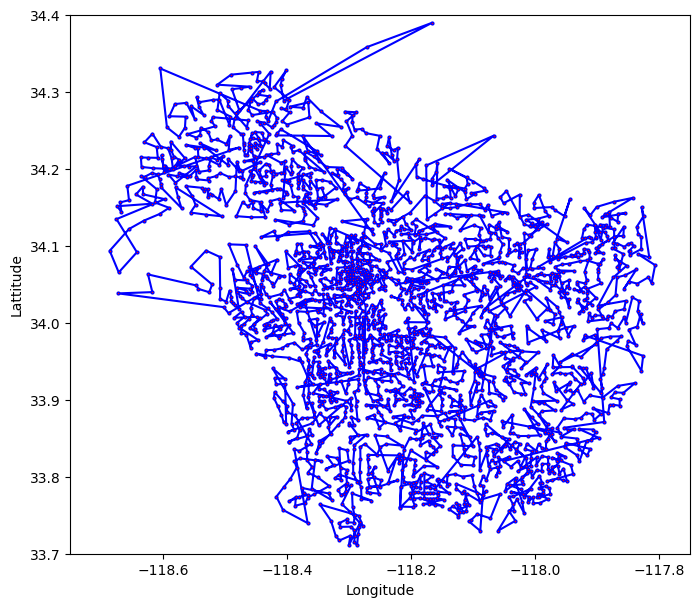

In [8]:
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(x,y,color='blue',marker='o',markersize=2,markerfacecolor='red')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(-118.75,   -117.75)
ax.set_ylim(33.7, 34.4)
plt.savefig('Q13.png',dpi=300,bbox_inches='tight')
plt.show()

### Question 14
Plot the road mesh that you obtain and explain the result. Create a graph $G_{\Delta}$ whose nodes are different locations and its edge are produced by triangulation.

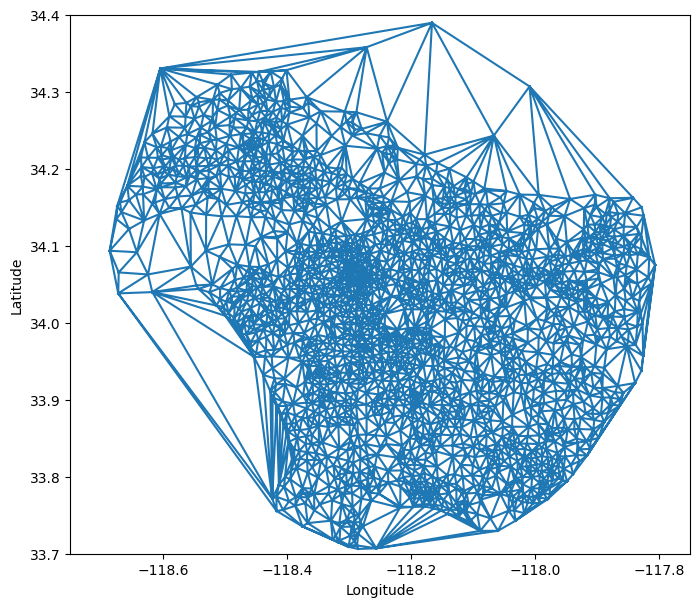

In [9]:
coordinates_dict = {}

with open('los_angeles_censustracts.json', 'r') as file:
    json_data = json.loads(file.readline())
    features_list = json_data['features']
    
    for feature in features_list:
        lat_sum = 0.0
        long_sum = 0.0
        
        if feature['geometry']['type'] == 'Polygon':
            coords = np.array(feature['geometry']['coordinates'][0])
        elif feature['geometry']['type'] == 'MultiPolygon':
            coords = np.array(feature['geometry']['coordinates'][0][0])
        
        for coord in coords:
            lat_sum += coord[1]
            long_sum += coord[0]
        
        avg_lat = lat_sum / len(coords)
        avg_long = long_sum / len(coords)
        
        coordinates_dict[feature['properties']['MOVEMENT_ID']] = (feature['properties']['DISPLAY_NAME'], avg_lat, avg_long)

latitudes = []
longitudes = []

for key in range(1, len(coordinates_dict) + 1):
    latitudes.append(coordinates_dict[str(key)][1])
    longitudes.append(coordinates_dict[str(key)][2])

lat_long_tuple = tuple(zip(latitudes, longitudes))
delaunay_result = Delaunay(lat_long_tuple)

fig, ax = plt.subplots(figsize=(8, 7))
plt.triplot(longitudes, latitudes, delaunay_result.simplices)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-118.75, -117.75)
ax.set_ylim(33.7, 34.4)

plt.savefig('Q14a.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Initialize the graph and add vertices
graph_delaunay = ig.Graph()
graph_delaunay.add_vertices(len(delaunay_result.points))

# Initialize a set to remove duplicate edges
unique_edges = set()

# Add edges to the graph
for simplex in delaunay_result.simplices:
    edge1 = (simplex[0], simplex[1])
    edge2 = (simplex[0], simplex[2])
    edge3 = (simplex[1], simplex[2])
    
    for edge in [edge1, edge2, edge3]:
        sorted_edge = tuple(sorted(edge))
        if sorted_edge not in unique_edges:
            unique_edges.add(sorted_edge)
            graph_delaunay.add_edges([sorted_edge])

# Plot and save the graph
plot = ig.plot(graph_delaunay, vertex_size=2)
plot.save('Q14b.png')
plot

### Question 16
Calculate the maximum number of cars that can commute per hour from Malibu to Long Beach. Also calculate the number of edge-disjoint paths between the two spots. Does the number of edge-disjoint paths match that you see on your road map?

In [21]:
# Coordinates for Malibu and Long Beach
malibu_coords = [34.026, -118.78]
long_beach_coords = [33.77, -118.18]

# Calculate the velocity of the car
velocity_car = (69 * np.sqrt((malibu_coords[0] - long_beach_coords[0]) ** 2 + (malibu_coords[1] - long_beach_coords[1]) ** 2)) / 1.05

# Calculate the maximum number of cars
max_cars = (3600 * velocity_car) / (5.4 + velocity_car)

# Initialize minimum distances and node indices
min_distance_long_beach = np.inf
min_distance_malibu = np.inf
closest_node_long_beach = 0
closest_node_malibu = 0

# Iterate through each coordinate to find the closest nodes
for index in range(1, len(lat_long_tuple)):
    distance_to_long_beach = np.sqrt(((lat_long_tuple[index][0]) - long_beach_coords[0]) ** 2 + ((lat_long_tuple[index][1]) - long_beach_coords[1]) ** 2)
    distance_to_malibu = np.sqrt((malibu_coords[0] - lat_long_tuple[index][0]) ** 2 + (malibu_coords[1] - lat_long_tuple[index][1]) ** 2)
    
    if distance_to_long_beach < min_distance_long_beach:
        min_distance_long_beach = distance_to_long_beach
        closest_node_long_beach = index
    
    if distance_to_malibu < min_distance_malibu:
        min_distance_malibu = distance_to_malibu
        closest_node_malibu = index

# Print the results
print('Number of edge-disjoint paths: ', graph_delaunay.adhesion(closest_node_long_beach, closest_node_malibu) - 1)
print('Degree Distribution of nodes (Malibu, Long Beach): ', graph_delaunay.degree(closest_node_malibu, mode='out'), graph_delaunay.degree(closest_node_long_beach, mode='in'))


Number of edge-disjoint paths:  5
Degree Distribution of nodes (Malibu, Long Beach):  6 6


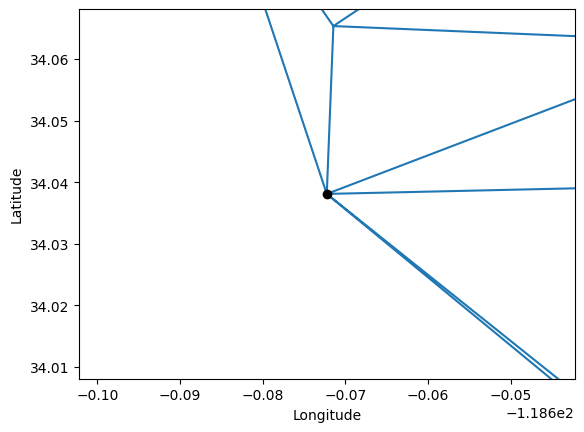

In [12]:
plt.triplot(longitudes, latitudes, delaunay_result.simplices)
plt.ylim(lat_long_tuple[closest_node_malibu][0]-0.03,lat_long_tuple[closest_node_malibu][0]+0.03)
plt.xlim(lat_long_tuple[closest_node_malibu][1]-0.03,lat_long_tuple[closest_node_malibu][1]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(longitudes[closest_node_malibu], latitudes[closest_node_malibu],'o',color='black')
plt.savefig('Q16a.png',dpi=300,bbox_inches='tight')
plt.show()

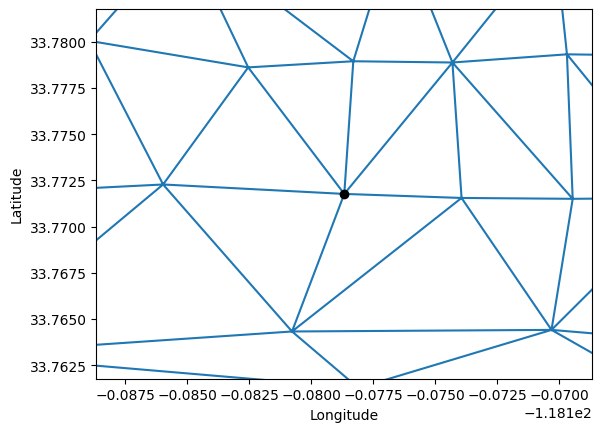

In [13]:
plt.triplot(longitudes, latitudes, delaunay_result.simplices)
plt.ylim(lat_long_tuple[closest_node_long_beach][0]-0.01,lat_long_tuple[closest_node_long_beach][0]+0.01)
plt.xlim(lat_long_tuple[closest_node_long_beach][1]-0.01,lat_long_tuple[closest_node_long_beach][1]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(longitudes[closest_node_long_beach], latitudes[closest_node_long_beach],'o',color='black')
plt.savefig('Q16b.png',dpi=300,bbox_inches='tight')
plt.show()

### Question 17
Plot $\widetilde{G}_{\Delta}$ on actual coordinates. Do you think the thresholding method worked?

In [14]:
# Initialize a new graph for the pruned Delaunay triangulation
delaunay_pruned_graph = ig.Graph()
delaunay_pruned_graph.add_vertices(len(delaunay_result.points))
graph_vertices = delaunay_pruned_graph.vs()

# Add latitude and longitude attributes to each vertex
for idx, vertex in enumerate(graph_vertices):
    vertex['latitude'] = latitudes[idx]
    vertex['longitude'] = longitudes[idx]

# Define the distance threshold
max_distance = (19.2 / 69)

# Initialize sets to track unique edges and edges to be removed
seen_edges = set()
edges_to_remove_set = set()

# Iterate through each simplex to add edges or mark for removal
for tri in delaunay_result.simplices:
    edge_pairs = [(tri[0], tri[1]), (tri[0], tri[2]), (tri[1], tri[2])]
    
    for edge in edge_pairs:
        sorted_edge = tuple(sorted(edge))
        if sorted_edge not in seen_edges:
            seen_edges.add(sorted_edge)
            lat_difference = graph_vertices[sorted_edge[0]]['latitude'] - graph_vertices[sorted_edge[1]]['latitude']
            lon_difference = graph_vertices[sorted_edge[0]]['longitude'] - graph_vertices[sorted_edge[1]]['longitude']
            edge_distance = np.sqrt(lat_difference**2 + lon_difference**2)
            
            if edge_distance < max_distance:
                delaunay_pruned_graph.add_edges([sorted_edge])
            else:
                edges_to_remove_set.add(sorted_edge)

# Convert the set of edges to be removed to a list
edges_to_remove_list = list(edges_to_remove_set)

# Filter simplices to create the new Delaunay output without the removed edges
pruned_simplices = [list(tri) for tri in delaunay_result.simplices if not any(set(edge).issubset(tri) for edge in edges_to_remove_list)]

# Resulting simplices without the edges that exceed the threshold distance
resulting_delaunay_simplices = [tri for tri in delaunay_result.simplices if tri not in np.array(pruned_simplices)]

In [15]:
g_del_prune=ig.Graph()
g_del_prune.add_vertices(len(delaunay_result.points))
nodes=g_del_prune.vs()
i=0
for node in nodes:
    node['latitude']=latitudes[i]
    node['longitude']=longitudes[i]
    i+=1

threshold=(19.2/69)

duplicate_remove=set()
edge_cut=set()
for i in range(len(delaunay_result.simplices)):
    a=((delaunay_result.simplices[i][0], delaunay_result.simplices[i][1]))
    b=((delaunay_result.simplices[i][0], delaunay_result.simplices[i][2]))
    c=((delaunay_result.simplices[i][1], delaunay_result.simplices[i][2]))
    list(a).sort()
    list(b).sort()
    list(c).sort()
    if not a in duplicate_remove:
        duplicate_remove.add(a)
        a_dist_check=np.sqrt((nodes[a[0]]['latitude']-nodes[a[1]]['latitude'])**2+(nodes[a[0]]['longitude']-nodes[a[1]]['longitude'])**2)
        if a_dist_check<threshold:
            g_del_prune.add_edges([a])
        else:
            edge_cut.add(a)
    if not b in duplicate_remove:
        duplicate_remove.add(b)
        b_dist_check=np.sqrt((nodes[b[0]]['latitude']-nodes[b[1]]['latitude'])**2+(nodes[b[0]]['longitude']-nodes[b[1]]['longitude'])**2)
        if b_dist_check<threshold:
            g_del_prune.add_edges([b])
        else:
            edge_cut.add(b)
    if not c in duplicate_remove:
        duplicate_remove.add(c)
        c_dist_check=np.sqrt((nodes[c[0]]['latitude']-nodes[c[1]]['latitude'])**2+(nodes[c[0]]['longitude']-nodes[c[1]]['longitude'])**2)
        if c_dist_check<threshold:
            g_del_prune.add_edges([c])
        else:
            edge_cut.add(c)
            
edge_cut_list=list(edge_cut)
simplices_list=[]
for simplex in delaunay_result.simplices:
    for edge in edge_cut_list:
        if edge[0] in simplex and edge[1] in simplex:
            simplices_list.append(list(simplex))
        
new_delaunay_out_desimplices = [i for i in delaunay_result.simplices if i not in np.array(simplices_list)]

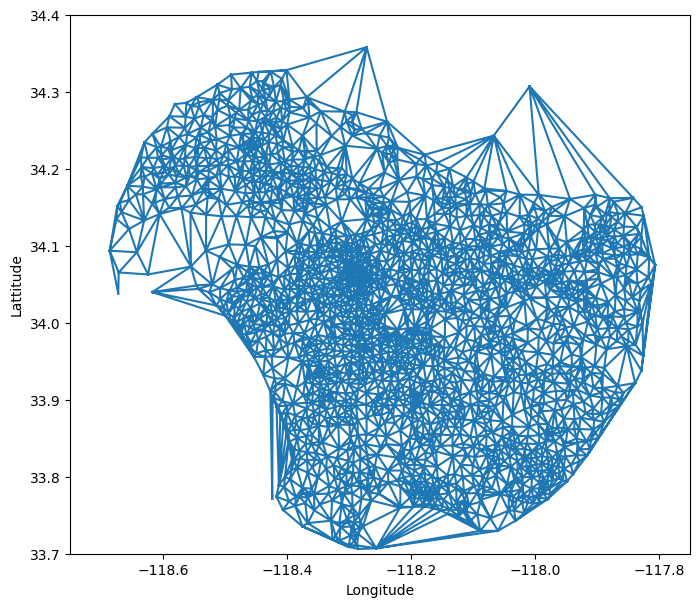

In [16]:
fig, ax = plt.subplots(figsize = (8,7))
plt.triplot(longitudes, latitudes, new_delaunay_out_desimplices)
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(-118.75,   -117.75)
ax.set_ylim(33.7, 34.4)
plt.savefig('Q17a.png',dpi=300,bbox_inches='tight')
plt.show()

In [17]:
out = ig.plot(g_del_prune, vertex_size=3)
out.save('17b.png')
out

### Question 18
Now, repeat question 13 for $\widetilde{G}_{\Delta}$ and report the results. Do you see any changes?

In [18]:
print('Number of edge-disjoint paths: ',delaunay_pruned_graph.adhesion(closest_node_long_beach,closest_node_malibu)-1)
print('Degree Distribution of nodes (Malibu, Long Beach): ', delaunay_pruned_graph.degree(closest_node_malibu,mode='out')-1,delaunay_pruned_graph.degree(closest_node_long_beach,mode='in')-1)

Number of edge-disjoint paths:  3
Degree Distribution of nodes (Malibu, Long Beach):  3 5


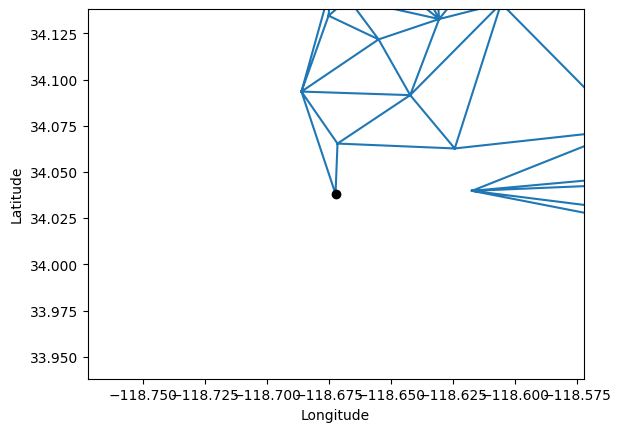

In [19]:
plt.triplot(longitudes, latitudes, new_delaunay_out_desimplices)
plt.ylim(lat_long_tuple[closest_node_malibu][0]-0.1,lat_long_tuple[closest_node_malibu][0]+0.1)
plt.xlim(lat_long_tuple[closest_node_malibu][1]-0.1,lat_long_tuple[closest_node_malibu][1]+0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(longitudes[closest_node_malibu], latitudes[closest_node_malibu],'o',color='black')
plt.savefig('Q18a.png',dpi=300,bbox_inches='tight')
plt.show()

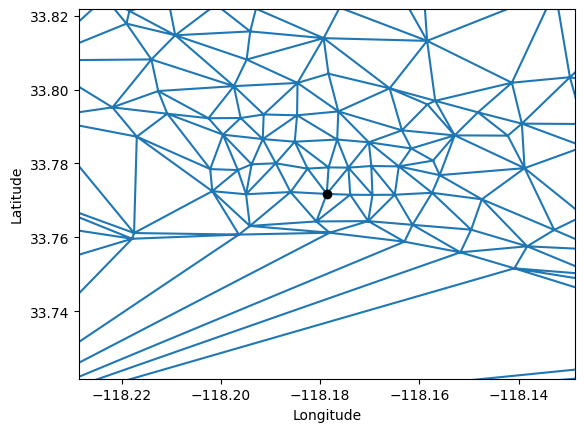

In [20]:
plt.triplot(longitudes, latitudes, new_delaunay_out_desimplices)
plt.ylim(lat_long_tuple[closest_node_long_beach][0]-0.05,lat_long_tuple[closest_node_long_beach][0]+0.05)
plt.xlim(lat_long_tuple[closest_node_long_beach][1]-0.05,lat_long_tuple[closest_node_long_beach][1]+0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(longitudes[closest_node_long_beach], latitudes[closest_node_long_beach],'o',color='black')
plt.savefig('Q18b.png',dpi=300,bbox_inches='tight')
plt.show()